In [ ]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [1]:
%autosave 0
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from functools import partial

Autosave disabled



# Computación paralela

En la clase pasada vimos como ganar rendimiento en operaciones SIMD usando NumPy

También aprendimos a conectar con lenguaje de bajo nivel usando Cython

Existe otra forma en que podemos ganar rendimiento en problemas que son "limitados en CPU"

El requisito adicional es que estos problemas sean separables

> Un problema es **separable** si puede dividirse en **subproblemas** que pueden resolverse de forma **independiente**

Al ser independientes significa que podemos resolverlos en **al mismo tiempo**, es decir resolver cada uno sin esperar el resultado de los demás

> Arquitectura de computadores: Hoy en día incluso los CPU de sobremesa son en realidad **múltiples CPU** unidos

Es decir que

> Podemos aprovechar los CPU multi-nucleo para resolver problemas separables en un menor tiempo

Esto es lo que llamamos [**computación paralela**](https://computing.llnl.gov/tutorials/parallel_comp/#Whatis)

> En la práctica muchos problemas de computación cientifícia (modelamiento, simulación) son paralelizables o incluso "masivamente paralelizables"

# Python y rendimiento | Parte 3

En esta clase veremos distintas formas para paralelizar código escrito en Python

Antes de empezar debemos estar al tanto de que: El manejo de memoría de CPython no es *thread-safe*

Es por esto que todo código escrito en Python está sujeto a un **mutex** que lo proteje: **Global Interpreter Lock (GIL)**

> El [GIL](https://wiki.python.org/moin/GlobalInterpreterLock) obliga a ejecutar solo un hilo de código Python a la vez

Además 

> El código escrito en Python no tiene control sobre el GIL

Por esta razón no es directo ni fácil que un proceso Python puedo usar múltiples CPU

En esta clase exploraremos dos alternativas generales

> **1:** No manipular el GIL y usar **multiples procesos**: *ipyparallel* y *joblib*


> **2:** Levantar el GIL con Cython y usar **múltiples hilos**: *openmp*, *joblib*


Existe una tercera alternativa más accesible pero exclusiva para hacer **algebra lineal en paralelo** con NumPy

> **3:** Compilar NumPy contra una librería de algebra lineal de alto rendimiento (MKL, ATLAS, Openblas)

Estas librerías usan código de bajo nivel que levanta el GIL

### Diferencias entre computación multi-proceso y multi-hilo

- Multi-proceso: Levantar **varios procesos** de Python (fork)
    - Los procesos tiene su propio espacio de memoria y su propio GIL
- Multi-hilo: Levantar varios hilos en **un proceso** de Python
    - Los hilos comparten memoria
    - Los hilos no se pueden ejecutar en paralelo a menos de que levanten el GIL (Cython)


# Computación multi-proceso con IPython: *ipyparallel*

[ipyparallel](https://ipyparallel.readthedocs.io/en/latest/) es un paquete independiente pero complementario de IPython para hacer computación multi-proceso

#### Instalación

Si tienes conda 

    conda install ipyparallel
    
Si usas pip

    pip install ipyparallel

Esto debería instalar en tu sistema unos ejecutables llamados `ipcluster`, `ipcontroller` e `ipengine`

Adicionalmente, en las versiones más nuevas, se crea una interfaz en la pestaña "Ipython clusters" del servidor jupyter llamada

Si la interfaz no aparece, se puede forzar con
    
    ipcluster nbextension enable
    
    
#### Conceptos y uso básico

*ipyparallel* considera varios elementos, los más importantes son:
- Engine: Es el encargado de correr código. Es una extensión del kernel de IPython
- Controller: Es una interfaz para comunicarnos con el/los engine/s. La conexión se hace a través del objeto `Client`

Para iniciar un controlador de forma automática abrimos un terminal y escribimos

    ipcluster start -n 4
    
o usamos los controles que se encuentran en la pestaña "IPython clusters" del servidor jupyter

Con esto hemos creado un controlador y cuatro engines, todos en nuestra máquina (localhost)

#### Creación de un cliente

In [2]:
# Importamos ipyparallel
import ipyparallel as ipp
# Creamos la clase cliente
rc = ipp.Client()
# Verificamos que se hayan iniciado nuestro engines
display(rc.ids)

[0, 1, 2, 3]

Cada engine tiene una id asociada

Para enviarle trabajo a los engines debemos crear una intefaz llamada [`View`](https://ipyparallel.readthedocs.io/en/latest/details.html#views)

Existen dos tipos de `View`: [*Direct*](https://ipyparallel.readthedocs.io/en/latest/direct.html#) y [*Task*](https://ipyparallel.readthedocs.io/en/latest/task.html#)

- La primera es controlada de forma explicita por el usuario
- La segunda es controlada por el sistema para *balancear la carga*
    
#### Enviando  trabajos usando interfaz Directa

Una `View` de tipo *Direct* requiere que el usuario especifique los engines que va a usar

Esto se hace de forma similar a los *slices* en listas/ndarray


Para crear una interfaz que utilice
- todas las engines, usamos `rc[:]`    
- las dos primeras engines, usamos `rc[:2]`

La vista puede hacerse bloqueante o no bloqueante (asíncrona) modificando el atributo booleano `block`

Una vista "bloqueante" espera a que el resultado de todos los engines sean retornado para devolver el control

In [3]:
# Creamos una view con
dview = rc[:]
# Por defecto es asíncrono (no bloqueante)
display(dview.block)
# Lo podemos cambiar con
dview.block = True
display(dview.block)

False

True

Los trabajos se envían usando las funciones de la `View` directa

- `apply`, `apply_sync`, `apply_async`: Ejecutan una función con argumentos
- `map`, `map_sync`, `map_async`: Ejecutan una función sobre una secuencia
    
Los apellidos `sync`  y `async` cambian el flag del view momentaneamente

- Cuando trabajamos en forma síncrona el resultado retorna al final de la ejecuación
- Cuando trabajamos de forma asíncrona se retorna un objeto [`AsyncResult`](https://ipyparallel.readthedocs.io/en/latest/asyncresult.html#parallel-asyncresult) que puede ser consultado más tarde por el resultado

#### Funciones de Python en paralelo con `apply`

Se ocupa como 

    rc[:].apply(f, *args, **kwargs)

    
Por ejemplo usando una función anónima

In [4]:
dview.apply(lambda : "Hola Mundo")

['Hola Mundo', 'Hola Mundo', 'Hola Mundo', 'Hola Mundo']

#### Compartiendo módulos y datos con los engines

Es importante tener claro que

> Los procesos en los engines no comparten memoria y no ven las variables que hemos en nuestro entorno local

Por ejemplo si queremos usar una función del módulo `os`

In [10]:
#import os # Este import no lo ven los engines

def funcion():
    import os # Este si
    return os.getpid() 

# Cada uno tiene un pid distinto
dview.apply(funcion)

[22646, 22659, 22662, 22665]

Otra forma es usar la función `sync_imports()` para que los módulos que importamos se mantengan en los engines

In [11]:
with dview.sync_imports(local=True): # el módulo quedará importado también en nuestro ambiente local
    import os

def funcion2():
    return os.getpid() 

dview.apply(funcion2)

importing os on engine(s)


[22646, 22659, 22662, 22665]

#### Pasando un dato a todos los engines

Para enviar un objeto de Python que hayamos definido en el ambiente local podemos usar la función `push`

El objeto tiene que ser un diccionario

Luego podemos usar `pull` si queremos extraer una variable

Estas funciones tienen el atributo `targets` que permite apuntar a un subconjunto de *engines*

In [27]:
a = 100 # Esto no existe dentro de los engines

dview.push({'a': a}) # Ahora está en todos los engines

def funcion3(): 
    return a**2

display(dview.apply(funcion3)) # Ahora la función retorna correctamente

display(dview.pull('a', targets=[0,1]))

[10000, 10000, 10000, 10000]

[100, 100]

#### Distribuyendo datos a los engines

Si queremos distribuir datos en los engines podemos usar `scatter`

Luego podemos recuperar su valor usando `gather`

In [29]:
# Una lista con 7 elementos que será distribuida en los 4 engines usando scatter
dview.scatter('c', [1, 2, 3, 4, 5, 6, 7])

def funcion3(): 
    return c

display(dview.apply(funcion3))

# Luego la recuperamos con gather
display(dview.gather('c'))

[[1, 2], [3, 4], [5, 6], [7]]

[1, 2, 3, 4, 5, 6, 7]

Es posible distribuir arreglos de NumPy

> Los arreglos de NumPy no se copian, se traspasan *read-only*

In [85]:
datos = np.random.randn(1000, 1000)
dview.scatter('data', datos)

def funcion4(): 
    # data[0, 0] = 0 # No podemos hacer esto!
    return data.shape

# Se particiona en 4 matrices por fila (row-major)
display(dview.apply(funcion4))

[(250, 1000), (250, 1000), (250, 1000), (250, 1000)]

Si queremos hacer modificaciones inplace tenemos que activar el flag `track`

In [89]:
display(dview.track)
dview.track = True

dview.scatter('data', datos)

def funcion5(): 
    data[0, 0] = 0 # No podemos hacer esto!
    return data[0, 0]

# Se particiona en 4 matrices por fila (row-major)
display(dview.apply(funcion5))

True

True

CompositeError: one or more exceptions from call to method: funcion5
[0:apply]: ValueError: assignment destination is read-only
[1:apply]: ValueError: assignment destination is read-only
[2:apply]: ValueError: assignment destination is read-only
[3:apply]: ValueError: assignment destination is read-only

#### Funciones remotas con decoradores

Podemos crear una función que es siempre ejecutada por los engines usando el decorador `remote`

Por ejemplo:

In [9]:
@dview.remote(block=True)
def funcion():
    return os.getpid()

funcion()

[22646, 22659, 22662, 22665]

Otros decorador interesante es `parallel` que convierte distribuye una función element-wise a los distintos engines

#### map

Se ocupa de forma equivalente al map de Python

In [ ]:
# Map de Python
resultado_serial = list(map(lambda x: x, range(32)))
# Map de ipyparallel
resultado_paralelo = dview.map(lambda x: x, range(32))
# Resultados
np.allclose(resultado_serial, resultado_paralelo)

#### Resultado asíncrono

El resultado asíncrono es un objeto de clase [`AsyncResult`](https://ipyparallel.readthedocs.io/en/latest/asyncresult.html#parallel-asyncresult)

Luego podemos usar su función
- `ready` : Retorna un booleano con el estado de la tarea
- `get` : Retorna el resultado

In [ ]:
res_async = dview.map_async(lambda x: x, range(10))
# Resultado asincrono
display(res_async)
# Está listo?
display(res_async.ready())
# Esperamos hasta que este listo y lo recuperamos
while not res_async.ready():
    res = res_async.get()
display(res)

### Paralelizando el fractal de Julia

In [216]:
def init_variables(N):
    zi = np.linspace(-1, 1, num=N, endpoint=False)[:, None]
    zr = np.linspace(-2, 2, num=2*N, endpoint=False)[:, None]
    # Creamos arreglos de 2NxN para zi y zr 
    zi = np.repeat(zi, repeats=2*N, axis=1)
    zr = np.repeat(zr.T, repeats=N, axis=0)
    image = np.zeros_like(zr)
    return image, zi, zr

def evaluate_z(*args, maxiters=100):
    image, zi, zr = args
    cr, ci = -0.835, -0.2321
    nit = 0
    while nit < maxiters:
        zr2 = zr*zr # operaciones vectoriales
        zi2 = zi*zi
        mask = zr2 + zi2 <= 4. #mascara booleana
        image[mask] += 1
        zi[mask] = 2*zr[mask]*zi[mask] + ci
        zr[mask] = zr2[mask] - zi2[mask] +  cr
        nit += 1
    return image
        

In [217]:
N = 2000

In [218]:
%%timeit -r5 -n1
image, zi, zr = init_variables(N);
image_serial = evaluate_z(image, zi, zr)

4.84 s ± 68.8 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


<IPython.core.display.Javascript object>


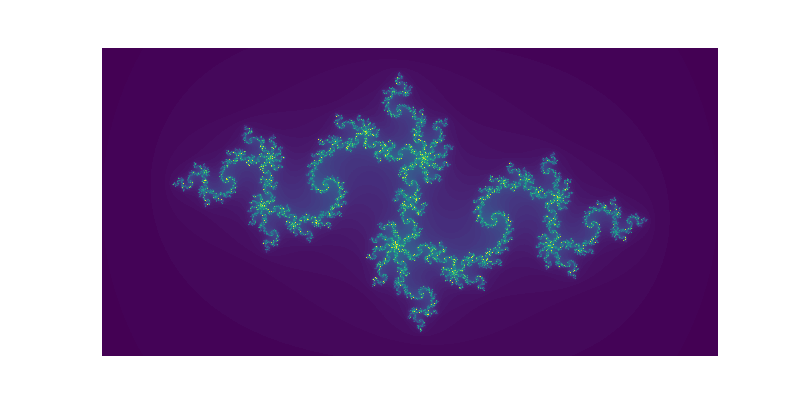

In [211]:
image, zi, zr = init_variables(N);
image_serial = evaluate_z(image, zi, zr)

fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
ax.imshow(image_serial);

In [212]:
with dview.sync_imports(local=True): # el módulo quedará importado también en nuestro ambiente local
    import numpy as np

importing numpy on engine(s)


https://ipyparallel.readthedocs.io/en/latest/details.html

In [220]:
%%timeit -r5 -n1 

image, zi, zr = init_variables(N)
res = dview.map(evaluate_z, zip(image, zi, zr), maxiters=50)

TypeError: invalid keyword arg, 'maxiters'

4

(500, 4000)

(2000, 4000)

<IPython.core.display.Javascript object>


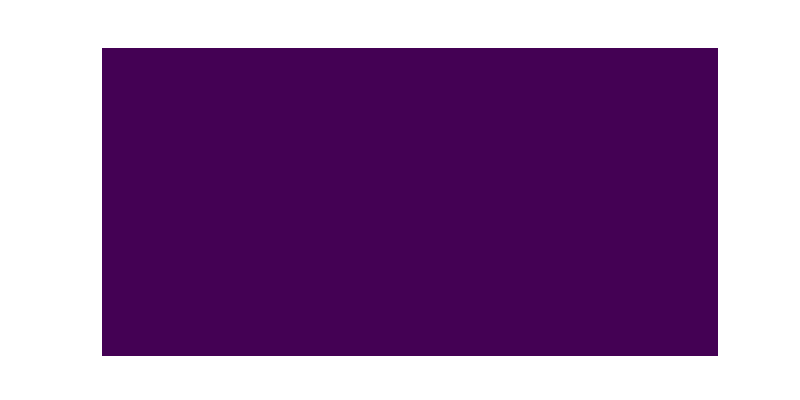

In [193]:
res = dview.apply(evaluate_z)
display(len(res))
display(res[0].shape)
image_parallel = np.concatenate(np.array(res), axis=0)
display(image_parallel.shape)
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
ax.imshow(image_parallel);

In [ ]:

dview.scatter('image', image)
dview.scatter('zi', zi)
dview.scatter('zr', zr)

def evaluate_z(zi, zr):
    cr, ci = -0.835, -0.2321
    nit = 0
    while nit < maxiters:
        zr2 = zr*zr # operaciones vectoriales
        zi2 = zi*zi
        mask = zr2 + zi2 <= 4. #mascara booleana
        image[mask] += 1
        zi[mask] = 2*zr[mask]*zi[mask] + ci
        zr[mask] = zr2[mask] - zi2[mask] +  cr
        nit += 1
    return nit

res = 

In [46]:
def make_fractal_vectorized(N, maxiters=50):
    image = np.zeros(shape=(N, 2*N), dtype=np.int64)
    zi = np.linspace(-1, 1, num=N, endpoint=False)[:, None]
    zr = np.linspace(-2, 2, num=2*N, endpoint=False)[:, None]
    # Creamos arreglos de 2NxN para zi y zr 
    zi = np.repeat(zi, repeats=2*N, axis=1)
    zr = np.repeat(zr.T, repeats=N, axis=0)
    cr, ci = -0.835, -0.2321
    nit = 0
    while nit < maxiters:
        zr2 = zr*zr # operaciones vectoriales
        zi2 = zi*zi
        mask = zr2 + zi2 <= 4. #mascara booleana
        image[mask] += 1
        zi[mask] = 2*zr[mask]*zi[mask] + ci
        zr[mask] = zr2[mask] - zi2[mask] +  cr
        nit += 1
    return image

# Los resultados comparados:
make_fractal_vectorized(500)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#### Tópicos extra

- [Magias de ipyparallel](https://ipyparallel.readthedocs.io/en/latest/magics.html)
- Balance de carga automático con la [interfaz Task](https://ipyparallel.readthedocs.io/en/latest/task.html#)
- [Depedencias entre procesos paralelos](https://ipyparallel.readthedocs.io/en/latest/dag_dependencies.html)
- Es posible conectar controladores y engines en distintas máquinas para hacer **computación distribuida** en base a [MPI](https://ipyparallel.readthedocs.io/en/latest/mpi.html)  usando [`ipengine` e `ipcontroller`](https://ipyparallel.readthedocs.io/en/latest/process.html#using-the-ipcontroller-and-ipengine-commands)

In [ ]:
from multiprocessing import Process

def foo():
    print('hello')

p = Process(target=foo)
p.start()

https://github.com/mynameisfiber/high_performance_python

https://joblib.readthedocs.io/en/latest/parallel.html

In [ ]:
from math import sin, exp
from joblib import Parallel, delayed


In [ ]:
%%time
N = 100000000
a = [sum([1]*N) for i in range(4)]

In [ ]:
%%time 
b = Parallel(n_jobs=4)(delayed(lambda x: sum([1]*N))(i) for i in range(4))

In [ ]:
np.allclose(a, b)

## Liberando el GIL en Cython

https://ipython-books.github.io/57-releasing-the-gil-to-take-advantage-of-multi-core-processors-with-cython-and-openmp/

- Multiprocessing

https://pjryan126.github.io/multiprocessing-in-python/

https://github.com/jupyter/notebook/issues/1703

https://medium.com/@grvsinghal/speed-up-your-code-using-multiprocessing-in-python-36e4e703213e

https://medium.com/@grvsinghal/speed-up-your-python-code-using-multiprocessing-on-windows-and-jupyter-or-ipython-2714b49d6fac

# Computación de alto rendimiento

Ciertos problemas son tan extensos que para solucionarlos en un tiempo razonable se requiere poder de cómputo y/o memoria superior a la ofrecida por un computador de arquitectura tradicional

Si el problema es separable entonces puede resolverse de forma eficiente usando computación paralela y/o distribuida

La computación de alto rendimiento o *high-performance computing* (HPC) es la disciplina que se dedica a diseñar algoritmos eficientes que utilizan arquitecturas paralelas/distribuidas avanzadas

En HPC también se investiga la utilización eficiente de co-procesadores de alto paralelismo como son los procesadores de tipo *many-core* (Xeon-Phi) y las Graphical Processing Units (GPU, Nvidia, AMD)

El Magíster en Informática de la UACh tiene a HPC como una de sus áreas principales

Más información en: http://www.ingenieria.uach.cl/index.php/postgrado/magister-en-informatica

In [44]:
import pycuda.driver as drv
import pycuda.tools
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
from pycuda.elementwise import ElementwiseKernel

complex_gpu = ElementwiseKernel(
    "pycuda::complex<float> *q, int *output, int maxiter",
    """
    {
        float nreal, real = 0;
        float imag = 0;
        output[i] = 0;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            float real2 = real*real;
            float imag2 = imag*imag;
            nreal = real2 - imag2 + q[i].real();
            imag = 2* real*imag + q[i].imag();
            real = nreal;
            if (real2 + imag2 > 4.0f){
                output[i] = curiter;
                break;
                };
        };
    }
    """,
    "complex5",
    preamble="#include <pycuda-complex.hpp>",)

def mandelbrot_gpu(c, maxiter):
    q_gpu = gpuarray.to_gpu(c.astype(np.complex64))
    iterations_gpu = gpuarray.to_gpu(np.empty(c.shape, dtype=np.int))
    complex_gpu(q_gpu, iterations_gpu, maxiter)

    return iterations_gpu.get()

In [45]:
c = np.zeros(shape=(500, 1000))
mandelbrot_gpu(c, 50)

ExecError: error invoking 'nvcc --preprocess -arch sm_61 -I/usr/lib/python3.7/site-packages/pycuda/cuda /tmp/tmpbzlf0j1o.cu --compiler-options -P': [Errno 2] No such file or directory: 'nvcc': 'nvcc'

In [43]:
%%bash
PATH=$PATH:/opt/cuda/bin
nvcc --version
export CUDA_ROOT=/opt/cuda

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Apr_24_19:10:27_PDT_2019
Cuda compilation tools, release 10.1, V10.1.168
